<a href="https://colab.research.google.com/github/puginarug/Image-Analysis-71254/blob/main/Copy_of_Lecture06_Class_Exercise06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Class 06**



For class 07, sign up here for GEE with your private Google account (not HUJI): https://signup.earthengine.google.com/

## **Python Tip:** import your python file as a module


Find out my working directory:

In [2]:
!pwd # ! interacts with the operating system

/content


Change my working directory:

In [3]:
%cd /content/drive

/content/drive


Lets mount our drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now let's change our dir to /content/drive:

In [5]:
%cd /content/drive
!pwd

/content/drive
/content/drive


Now lets try to import a python file as a library. I want to import the display_img.py as a module:

In [6]:
# trying to import display_img
import display_image

ModuleNotFoundError: ignored

As you can see, there is not library called display_image!
Let's change the directory to the folder where our python file is located:

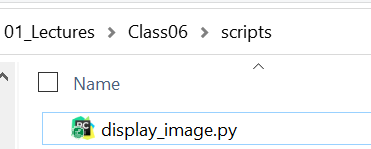

/content/drive/MyDrive/71254_2023/01_Lectures/Class06/scripts

In [7]:
%cd /content/drive/MyDrive/71254_2023/01_Lectures/Class06/scripts

/content/drive/.shortcut-targets-by-id/1YejzZF4yTd-VII_OgL9a-frHMMMIsjAy/71254_2023/01_Lectures/Class06/scripts


Let's just make sure that it worked:

In [8]:
%pwd

'/content/drive/.shortcut-targets-by-id/1YejzZF4yTd-VII_OgL9a-frHMMMIsjAy/71254_2023/01_Lectures/Class06/scripts'

Let's import again:

In [9]:
# trying to import display_img
import display_image

Great! No error now. Let's try to use the library

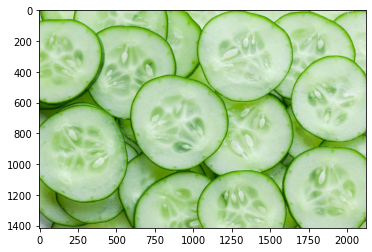

In [10]:
path_of_image = '/content/drive/MyDrive/71254_2023/01_Lectures/Class06/images/cucs.jpg' # from the drive
display_image.display_img_from_path(path_of_image) # using a function I wrote within the library

**Amazing! You can now create .py files with useful codes you wrote, upload them to your Drive or GitHub, and import them as module in order to use them frequently.**

In [11]:
!git clone https://github.com/Ali619/Object-Detection-Size-Measurement

fatal: destination path 'Object-Detection-Size-Measurement' already exists and is not an empty directory.


## **Segmentation**

Credit:


*   https://felipemeganha.medium.com/image-segmentation-with-watershed-using-python-f40f2f7e9f40
*   https://github.com/bnsreenu/python_for_microscopists
*   https://pyimagesearch.com/2015/11/02/watershed-opencv/
*   https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python



### **Image segmentation using watershed**


**Watershed segmentantion** is one of the most popular algorithm for image segmentation, normally used when we want to resolve one of the most difficult operations in image processing — separating similar objects in the image that are touching each other.

In essence, we partition the image into two different sets:


*   catchment basins — dark areas; The group of connected pixels with the same local minimum.
*   watershed lines — Lines that divide one catchment area from another.


**Workflow:**


1.   Binary image
2.   Calculate a distance transform
3.   Find local maxima points
4.   Label the marks




Let's start.

We'll import the necessary libraries and do image pre-processing:

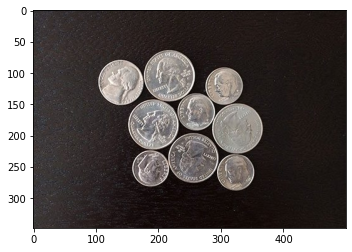

In [12]:
# images path dec
images_path = r'/content/drive/MyDrive/71254_2023/01_Lectures/Class06/images'

# import libs
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import io, img_as_ubyte

'''
The imutils library is a series of convenience functions to make basic image processing functions such as translation,
rotation, resizing, skeletonization, and displaying Matplotlib images easier with OpenCV and Python 3.'''
import imutils


# pre-processing
img = cv2.imread(f'{images_path}/watershed_coins.jpg') # read image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # bgr to rgb
plt.imshow(img_rgb)

Text(0.5, 1.0, 'Thresholded')

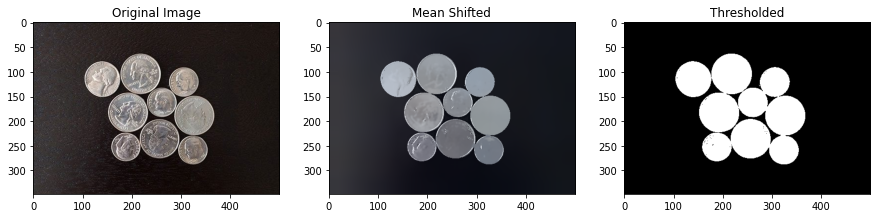

In [13]:
# continued

shifted = cv2.pyrMeanShiftFiltering(img, 21, 51) # mean shift filtering to aid the thresholding step. only for rgb. read more here: https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#pyrmeanshiftfiltering
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY) # color to gray
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# Now let us visualize the output result
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))

plt.subplot(1,3,1),plt.imshow(img_rgb)
plt.title('Original Image')

plt.subplot(1,3,2),plt.imshow(shifted, cmap='gray')
plt.title('Mean Shifted')

plt.subplot(1,3,3),plt.imshow(thresh, cmap='gray')
plt.title('Thresholded')

Now we can apply our watershed.

The first step in applying the watershed algorithm for segmentation is to compute the Euclidean Distance Transform (EDT) via the distance_transform_edt function. As the name suggests, this function computes the Euclidean distance to the closest zero (i.e., background pixel) for each of the foreground (our coins) pixels.

In [14]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)

# Now we take D , our distance map, and find peaks (i.e., local maxima) in the map. We’ll ensure that is at least a 20 pixel distance between each peak.
localMax = peak_local_max(D, indices=False, min_distance=10,
	labels=thresh)

<ipython-input-14-0cd5c39a2e02>:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=10,


Now we take the output of the peak_local_max function and apply a connected-component analysis using 8-connectivity. The output of this function gives us our markers which we then feed into the watershed function. 

Since the watershed algorithm assumes our markers represent local minima (i.e., valleys) in our distance map, we take the negative value of D.

The watershed function returns a matrix of labels , a NumPy array with the same width and height as our input image. Each pixel value as a unique label value. Pixels that have the same label value belong to the same object.

In [15]:
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh) #  matrix of labels
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

[INFO] 9 unique segments found


The last step is to simply loop over the unique label values and extract each of the unique objects:

Object number 1 has an area =  5201.0
Object number 2 has an area =  4019.0
Object number 3 has an area =  2755.5
Object number 4 has an area =  2746.5
Object number 5 has an area =  5047.5
Object number 6 has an area =  5030.0
Object number 7 has an area =  4985.5
Object number 8 has an area =  2637.5
Object number 9 has an area =  2690.0


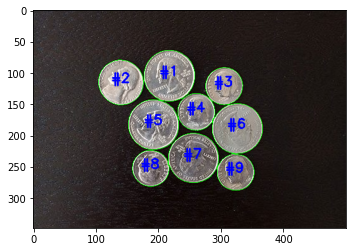

In [16]:
# loop over the unique labels returned by the Watershed algorithm
total_area = [] # list to store areas of onjects

for i,label in enumerate(np.unique(labels)):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region, and set the pixels belonging to the current label to 255 (white). draw it on the mask.
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255


	# detect contours in the mask and grab the largest one — this contour will represent the outline/boundary of a given object in the image.
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
	
	# calc area and append to list
	area = cv2.contourArea(c)
	total_area.append(area)
	print(f'Object number {i} has an area = ', area)
 	
 
	# draw the contours enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)  # We find the circumcircle of an object using the function cv.minEnclosingCircle(). It is a circle which completely covers the object with minimum area.
	cv2.putText(img_rgb, "#{}".format(label), (int(x) - 15 , int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) # draw the ID on the object
	cv2.drawContours(img_rgb, cnts, -1, (0,255,0), 1) # draw the counters
 
# show the output image
plt.imshow(img_rgb)

As you can see, we have successfully detected all nine coins in the image. Furthermore, we have been able to cleanly draw the boundaries surrounding each coin as well.

##### **TODO:** 


Write a function that will take two arguments: an image path, and min_distance (for peak_local_max). The function should display the image segmented using watershed. Test your final function, on the coins image above.

Tips:


*   cv2.pyrMeanShiftFiltering() needs RGB image. If you're source image is grayscale, then don't apply cv2.pyrMeanShiftFiltering() (and of course don't cv2.COLOR_BGR2GRAY).
*   You may need to convert source image to 8-bit prior watershed steps.





In [ ]:
# your code goes here

In [17]:
def segment_img (img_path, min_distance):

  image = img_as_ubyte(io.imread(fname=f"{img_path}")) #reading the image and converting to 8-bit

  if img.shape[2] == 3: #for RGB images
    shifted = cv2.pyrMeanShiftFiltering(img, 21, 51) # mean shift filtering to aid the thresholding step. only for rgb. read more here: https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#pyrmeanshiftfiltering
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY) # color to gray
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  else:
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

  # compute the exact Euclidean distance from every binary
  # pixel to the nearest zero pixel, then find peaks in this
  # distance map
  D = ndimage.distance_transform_edt(thresh)

  # Now we take D , our distance map, and find peaks (i.e., local maxima) in the map. We’ll ensure that is at least a 20 pixel distance between each peak.
  localMax = peak_local_max(D, indices=False, min_distance=min_distance,
	  labels=thresh)

  # perform a connected component analysis on the local peaks,
  # using 8-connectivity, then appy the Watershed algorithm
  markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
  labels = watershed(-D, markers, mask=thresh) #  matrix of labels

  # loop over the unique labels returned by the Watershed algorithm
  total_area = [] # list to store areas of onjects

  for i,label in enumerate(np.unique(labels)):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
      continue
    # otherwise, allocate memory for the label region, and set the pixels belonging to the current label to 255 (white). draw it on the mask.
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255


    # detect contours in the mask and grab the largest one — this contour will represent the outline/boundary of a given object in the image.
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
      cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # calc area and append to list
    area = cv2.contourArea(c)
    total_area.append(area)
    
    # draw the contours enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)  # We find the circumcircle of an object using the function cv.minEnclosingCircle(). It is a circle which completely covers the object with minimum area.
    cv2.putText(image, "#{}".format(label), (int(x) - 15 , int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) # draw the ID on the object
    cv2.drawContours(image, cnts, -1, (0,255,0), 1) # draw the counters

  # show the output image
  plt.imshow(image)


<ipython-input-17-a72254794008>:18: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=min_distance,


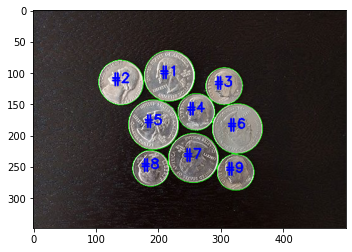

In [18]:
segment_img(f'{images_path}/watershed_coins.jpg', 10)

### **Image segmentation using Voronoi**


A Voronoi diagram divides the plane into separate regions where ​each region contains exactly one generating point (seed) and​ every point in a given region is closer to its seed than to any other. ​The regions around the edge of the cluster of points extend out to infinity. 

For more info, watch [here](https://www.youtube.com/watch?v=g5FnaNtcCzU).

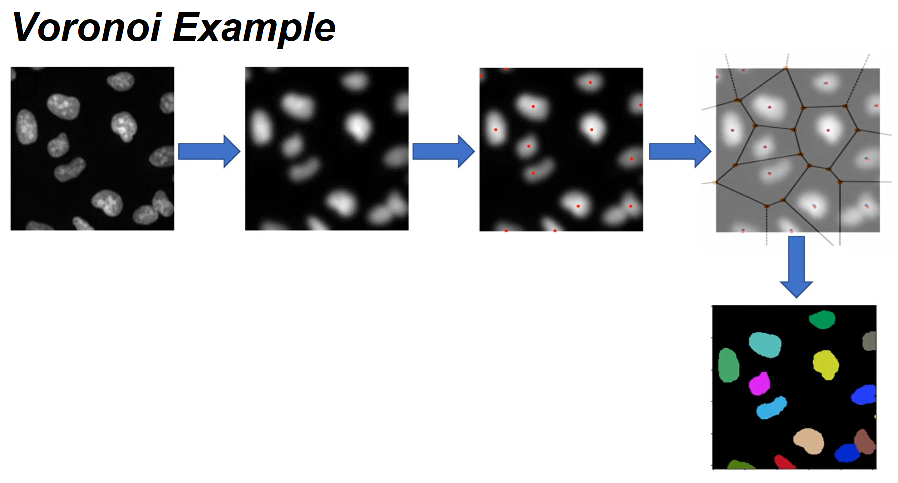


**How can Voronoi help with image segmentation?**


*   We can find object centers and use them as seeds for Voronoi.
*   Then threshold objects withing each voronoi region.


**Workflow:**


1.   Gaussian blur the image and detect maxima for each nuclei.
2.   Threshold the input image after applying light gaussian blur (sigma=1).
3.   Exclude maxima locations from the background, to make sure we only include the ones from nuclei.
4.   Separate maxima locations into labels using masked voronoi.
5.   Separate objects using watershed (wont always work).

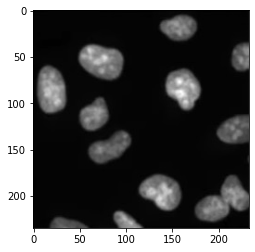

In [ ]:
# images path dec
images_path = r'/content/drive/MyDrive/71254_2023/01_Lectures/Class06/images'

# import libs
from skimage import io, filters
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib import pyplot as plt

# read an image of cells
img = io.imread(f'{images_path}/cells.jpg', as_gray = True)

# display it
plt.imshow(img, cmap='gray')

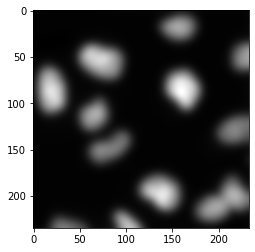

In [ ]:
# Step 1 - Gaussian blur to average local intensity variations (it will help out locate the cells in the image)
img_blurred = filters.gaussian(img, sigma=5)
plt.imshow(img_blurred, cmap='gray')

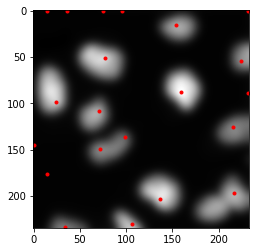

In [ ]:
# Step 2: Find the points representing each object, to be used for Voronoi
from skimage.feature import peak_local_max
coordinates = peak_local_max(img, min_distance=20, 
                             exclude_border=False)

# display the local max points on the blurred image
plt.imshow(img_blurred, cmap='gray')

# Plot y versus x as markers
# 'r.' draws the x,y as red points
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.') 

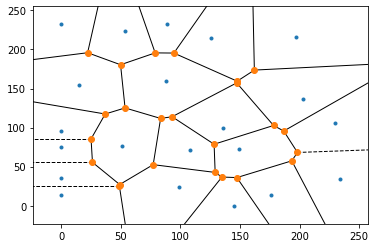

In [ ]:
# Step 3: Voronoi regions - we'll use the above points as seeds
vor3 = Voronoi(coordinates) # our Voronoi diagram based on the seeds
fig3 = voronoi_plot_2d(vor3) # creating a figure from the Voronoi diagram, so we can plot it
plt.show() # it will show fig3

#### Using pyclesperanto package to segment based on Voronoi+Otsu

In [ ]:
# first install the lib
!pip install pyclesperanto-prototype

# For installation instructions of the pyclesperanto package, 
# https://github.com/clEsperanto/pyclesperanto_prototype

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


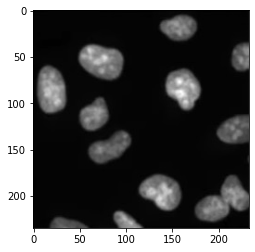

In [ ]:
# import libs
from matplotlib import pyplot as plt
import pyclesperanto_prototype as cle
from skimage import io

# read an image of cells
img = io.imread(f'{images_path}/cells.jpg', as_gray = True)

# display it
plt.imshow(img, cmap='gray')

In [ ]:
# preparing our GPU

# list names of all available GPU-devices
print("Available devices:" + str(cle.available_device_names()))

Available devices:['Tesla T4', 'cupy backend (experimental)']


Used GPU:  <Tesla T4 on Platform: NVIDIA CUDA (2 refs)>
Image size in GPU: (235, 233)


/usr/local/lib/python3.8/dist-packages/pyclesperanto_prototype/_tier9/_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


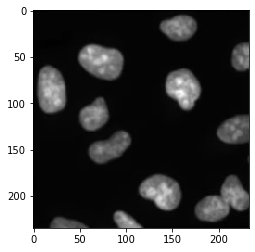

In [ ]:
# select a specific GPU device from the above
device = cle.select_device('Tesla T4')
print("Used GPU: ", device)

#Push the image to gpu memory
img_gpu = cle.push(img)
print("Image size in GPU: " + str(img_gpu.shape))

# display using cle (not plt)
cle.imshow(img_gpu, color_map='gray')

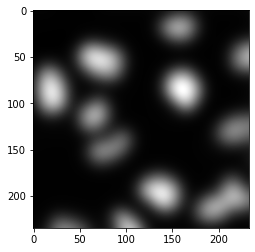

In [ ]:
# Step 1: heavy gaussian blur the image (e.g., sigma=12) and detect maxima for each nuclei
# heavy gaussian blurring assists in detecting maxima that reflects the objects.
# If objects are closer, you may want to decrease the amount of blurring.
img_gaussian = cle.gaussian_blur(img, sigma_x=8, sigma_y=8, sigma_z=8)
plt.imshow(img_gaussian, cmap='gray')

number of detected maxima locations 14.0


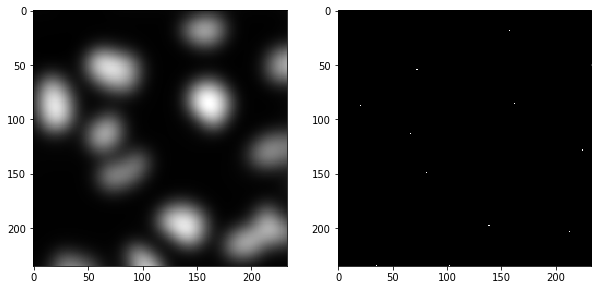

In [ ]:
# Find out the maxima locations for each 'blob'

img_maxima_locations = cle.detect_maxima_box(img_gaussian, radius_x=12, radius_y=12, radius_z=12)

# Number of maxima locations (= number of objects)
# This number depend on the amount of Gaussian blur
number_of_maxima_locations = cle.sum_of_all_pixels(img_maxima_locations) # sums the points detected
print("number of detected maxima locations", number_of_maxima_locations)

# View the blurred image and corresponding maxima locations
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
cle.imshow(img_gaussian, plot=axs[0], color_map='gray')
cle.imshow(img_maxima_locations, plot=axs[1], color_map='gray')

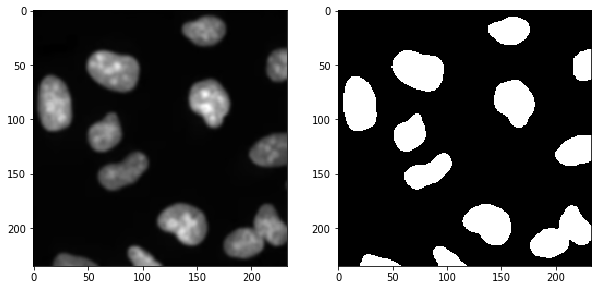

In [ ]:
# Step 2: Applying another (light) gaussian blur (sigma=1), to otsu threshold the input image
img_gaussian2 = cle.gaussian_blur(img, sigma_x=1, sigma_y=1, sigma_z=1)
img_thresh = cle.threshold_otsu(img_gaussian2) # thresholding using otsu with cle

# plotting and displaying
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
cle.imshow(img_gaussian2, plot=axs[0], color_map='gray')
cle.imshow(img_thresh, plot=axs[1], color_map='gray')

number of relevant maxima locations 12.0


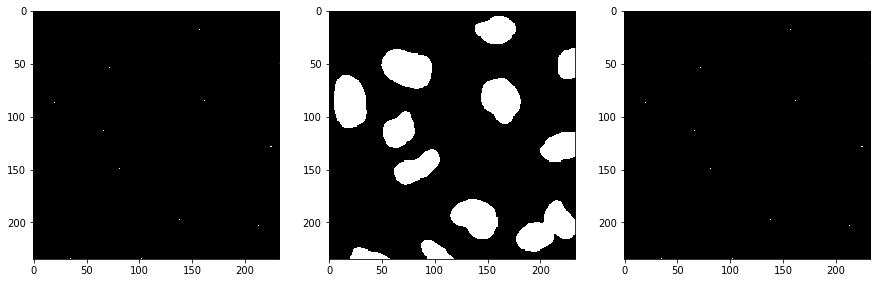

In [ ]:
# Step 3: Exclude maxima locations from the background, to make sure we only include the ones from nuclei

# We take the binary spots image and the binary segmentation image 
# and apply a binary_and operation to exclude spots which were detected in the background area. 
# Those likely corresponded to noise.
img_relevant_maxima = cle.binary_and(img_thresh, img_maxima_locations)

# counting the points again
number_of_relevant_maxima_locations = cle.sum_of_all_pixels(img_relevant_maxima)
print("number of relevant maxima locations", number_of_relevant_maxima_locations)

# displaying
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(img_maxima_locations, plot=axs[0], color_map='gray')
cle.imshow(img_thresh, plot=axs[1], color_map='gray')
cle.imshow(img_relevant_maxima, plot=axs[2], color_map='gray')


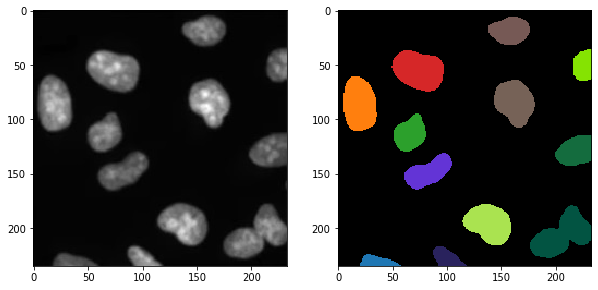

In [ ]:
# Step 4: Separate maxima locations into labels using masked voronoi

# Creates a mask within every Voronoi region
voronoi_separation = cle.masked_voronoi_labeling(img_relevant_maxima, img_thresh)

# Display
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
cle.imshow(img, plot=axs[0], color_map='gray')
cle.imshow(voronoi_separation, labels=True, plot=axs[1])


In [ ]:
# In order to save images from cle, you must save them as a tif file:
io.imsave(f'{images_path}/cells_thresh.tif', img_thresh)

<ipython-input-996-e5215f25dd9d>:2: UserWarning: /content/drive/MyDrive/71254_2023/01_Lectures/Class06/images/cells_thresh.tif is a low contrast image
  io.imsave(f'{images_path}/cells_thresh.tif', img_thresh)


##### **TODO:** 


1.   In step 3, after applying binary_and(), how many points have been removed? Can you identify them?
2.   In step 4, notice two cells connected to eachother. Why do you think that happened? Take a look at the blurred image at step 1.Try to seprate those two cells, by changing the sigma value in the **first** blur above. If you don't succeed, apply your watershed function (that you wrote in the previous section) on the binary thresholded image (img_thresh).



In [ ]:
# your answers go here

#### **Using pyclesperanto package to segment based on Voronoi+Otsu - SHORT**

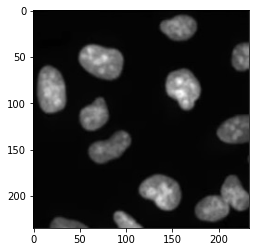

In [ ]:
# otsu + vor + labeling


from matplotlib import pyplot as plt
import numpy as np
import pyclesperanto_prototype as cle
from skimage import exposure, img_as_ubyte

#Read the input image
# read an image of cells
img = io.imread(f'{images_path}/cells.jpg', as_gray = True)

# display it
plt.imshow(img, cmap='gray')

#Normalize then scale to 255 and convert to uint8 - using skimage
cells_8bit = img_as_ubyte(img)
plt.imshow(cells_8bit, cmap='gray')

In [ ]:
# preparing our GPU

# list names of all available GPU-devices
print("Available devices:" + str(cle.available_device_names()))

Available devices:['Tesla T4', 'cupy backend (experimental)']


Used GPU:  <Tesla T4 on Platform: NVIDIA CUDA (2 refs)>
Image size in GPU: (235, 233)


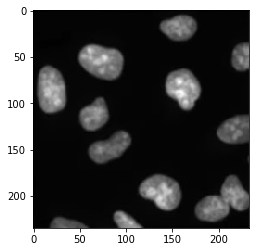

In [ ]:
# select a specific GPU device from the above
device = cle.select_device('Tesla T4')
print("Used GPU: ", device)

#Push the image to gpu memory
cells_gpu = cle.push(cells_8bit)
print("Image size in GPU: " + str(cells_gpu.shape))

# display
cle.imshow(cells_8bit, color_map='gray')

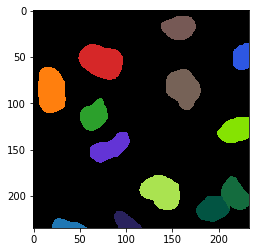

In [ ]:
############ voronoi_otsu_labeling library ##################
# voronoi_otsu_labeling(image, spot_sigma=some_number, outline_sigma=another_number)
#spot_sigma= depends on how close the detected objects can be. Low number may divide large objects into multiple objects.
#outline_sigma = how precise the outline needs to be for the segmented objects (use a low number)
segmented = cle.voronoi_otsu_labeling(cells_gpu, spot_sigma=5, 
                                      outline_sigma=1)
cle.imshow(segmented, labels=True)

**TODO:** Play with the spot_sigma value above and notice the differences.

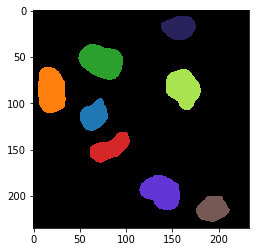

In [ ]:
# Remove edge touching objects
segmented_excl_edges = cle.exclude_labels_on_edges(segmented)
cle.imshow(segmented_excl_edges, labels=True)

**TODO:** Why would you exclude objects that are the edges?

**Answer:** here

In [ ]:
# Number of objects segmented
# The maxmium intensity in a label image corresponds to the number of objects
num_objects = cle.maximum_of_all_pixels(segmented_excl_edges)
print("Total objects detected are: ", num_objects)

Total objects detected are:  8.0


<ipython-input-1004-5f1f27bebfb2>:7: UserWarning: result.tif is a low contrast image
  io.imsave("result.tif", img_segmented_32bit_np)  # must save as tif


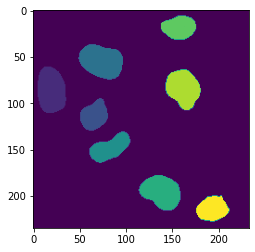

In [ ]:
# Save segmented image to disk
# save image to disk
import skimage.io
img_segmented_32bit_np = cle.pull(segmented_excl_edges) # pulls img from cle, convert to 32bit np array. each object has a diff int value
plt.imshow(img_segmented_32bit_np)  

io.imsave("result.tif", img_segmented_32bit_np)  # must save as tif

### **Image segmentation using Blob Detector**

(Only read the text below, don't practice in class. You can practice at home if you want)


Source: Apper_micro

**BLOB stands for Binary Large OBject** and refers to a group of connected pixels in a binary image. A Blob is a group of connected pixels in an image that share some common property ( e.g. grayscale value ). The goal of blob detection is to identify and mark these connected regions.

How it works:
1. Threshold input images to binary.
2. Grouping: connected white/black pixels are grouped together. 
3. Merging: blobs located closer than minDistBetweenBlobs are merged.
4. Center & Radius Calculation :  The centers and radii of the new merged blobs are computed and returned.
    
Can be filtered by color, size or shape.

Read [here](https://learnopencv.com/blob-detection-using-opencv-python-c/) about implementing the Blob Detector. You can watch [this](https://www.youtube.com/watch?v=2puHfSKnG7c) video for detailed explanation.

### **Image segmentation using K-Means**

K-Means clustering is an unsupervised machine learning algorithm that aims to partition N observations into K clusters in which each observation belongs to the cluster with the nearest mean. A cluster refers to a collection of data points aggregated together because of certain similarities. For image segmentation, clusters here are different image colors/values.

Click [here](https://qr.ae/pr7PZM) to read about what's the difference between Voronoi and K-means.

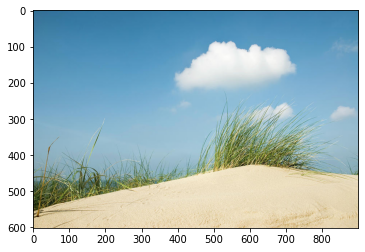

In [ ]:
#k means

__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"
# https://www.youtube.com/watch?v=6CqRnx6Ic48

import numpy as np
import cv2


# read an image of pebbles
img = io.imread(f'{images_path}/sand.jpg', as_gray = False)

# display it
plt.imshow(img, cmap='gray')

We going to use the cv2.kmeans() function, which takes a 2D array as input, and since our original image is 3D (width, height, and depth of 3 RGB values), we need to flatten the height and width into a single vector of pixels (3 RGB values):

In [ ]:
# Convert MxNx3 image into Kx3 where K=MxN
pixel_values  = img.reshape((-1,3))  #-1 reshape means, in this case MxN

#We convert the unit8 values to float as it is a requirement of the k-means method of OpenCV
pixel_values = np.float32(pixel_values)

Let's try to print the shape of the resulting pixel values:

In [ ]:
print(pixel_values.shape)
print(f'As expected, this results from flattening a high resolution {img.shape} image.')

(541800, 3)
As expected, this results from flattening a high resolution (602, 900, 3) image.


**Define criteria, number of clusters and apply k-means:**
We are going to stop the algorithm either when some number of iterations is exceeded (say 100), or if the clusters move less than some epsilon value (let's pick 0.2 here).

When this criterion is satisfied, the algorithm iteration stops. 
* cv.TERM_CRITERIA_EPS — stop the algorithm iteration if specified accuracy, epsilon, is reached.
* cv.TERM_CRITERIA_MAX_ITER — stop the algorithm after the specified number of iterations, max_iter.
* cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER — stop the iteration when any of the above condition is met.

The below code defines the stopping criteria in OpenCV:

In [ ]:
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

If you look at the image, there are four primary colors. As a result, we going to use 4 clusters for this image:

In [ ]:
# number of clusters (K)
k = 4

labels array is the cluster label for each pixel which is either 0, 1, or 2, etc.., centers refer to the center points (each centroid's value).

cv2.KMEANS_RANDOM_CENTERS just indicates OpenCV to randomly assign the values of the clusters initially.

attempts : Flag to specify the number of times the algorithm is executed using different initial labellings. The algorithm returns the labels that yield the best compactness. This compactness is returned as output.

In [ ]:
attempts = 10
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)

We converted the flattened image pixel values to floats; we did that because cv2.kmeans() expects that, let's convert them back to 8-bit pixel values:

In [ ]:
# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

Now let's construct the segmented image:

In [ ]:
# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

Converting back to the original image shape and showing it:

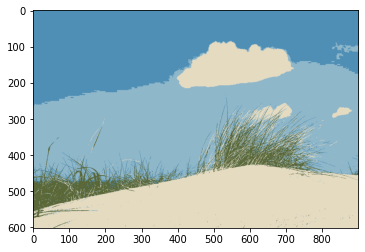

In [ ]:
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(img.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

Great! We can also disable some clusters in the image. For instance, let's exclue all pixels that aren't grass (= let's segment the grass):

In [ ]:
# we take a look at the centers of the diff objects
print(centers)

# from trial and error, I found that the row ([90,103,55]) is the grass!

[[ 90 103  55]
 [ 79 143 181]
 [143 183 202]
 [229 219 193]]


In [ ]:
# lets get the index of the grass row 

for i,center in enumerate(centers):
  if np.all(center == ([90,103,55])):
    grass_center_index = i
    print(grass_center_index)

0


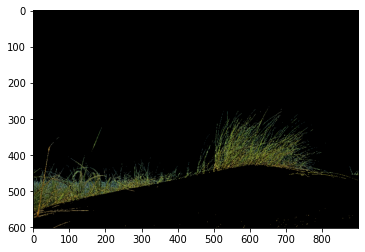

In [ ]:
# copy source img
masked_image = img.copy()

# convert to the shape of a vector of pixel values (like suits for kmeans)
masked_image = masked_image.reshape((-1, 3))

# color (i.e cluster) to exclude
list_of_cluster_numbers_to_exclude = list(range(k)) # create a list that has the number from 0 to k-1
list_of_cluster_numbers_to_exclude.remove(grass_center_index) # remove the cluster of grass that we want to keep, and not black out
for cluster in list_of_cluster_numbers_to_exclude:
  masked_image[labels== cluster] = [0, 0, 0] # black all clusters except cluster grass_center_index

# convert back to original shape
masked_image = masked_image.reshape(img.shape)

# show the image
plt.imshow(masked_image)

Object has an area =  19124.5 pixels


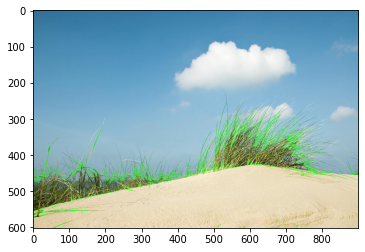

In [ ]:
# detect contours in an image and grab the largest one — this contour will represent the outline/boundary of a given object in the image.
gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY) # color to gray
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1] # threshold the gray
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # find the boundaries 
cnts = imutils.grab_contours(cnts) 
c = max(cnts, key=cv2.contourArea)

# draw the contours enclosing the object
cv2.drawContours(img, cnts, -1, (0,255,0), 1) # draw the counters

# calc number of pixels within the object and append to list
area = cv2.contourArea(c)
print(f'Object has an area = ', area, 'pixels')

plt.imshow(img, cmap='Greens')

**TODO:** How can the segmented grass be usefull for you? Assuming you have several images of above, during the entire summer (let's say, one image per week).

**Answer:** here!


Now let's try to segment our clouds:

In [ ]:
# we take a look at the centers of the diff objects
print(centers)

# from trial and error, I found that the row ([229,219,193]) is the clouds!

[[ 90 103  55]
 [ 79 143 181]
 [143 183 202]
 [229 219 193]]


In [ ]:
# lets get the index of the clouds row 

for i,center in enumerate(centers):
  if np.all(center == ([229,219,193])):
    clouds_center_index = i
    print(clouds_center_index)

3


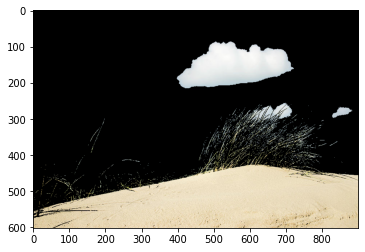

In [ ]:
# copy source img
masked_image = img.copy()

# convert to the shape of a vector of pixel values (like suits for kmeans)
masked_image = masked_image.reshape((-1, 3))

# color (i.e cluster) to exclude
list_of_cluster_numbers_to_exclude = list(range(k)) # create a list that has the number from 0 to k-1
list_of_cluster_numbers_to_exclude.remove(clouds_center_index) # remove the cluster of clouds that we want to keep, and not black out
for cluster in list_of_cluster_numbers_to_exclude:
  masked_image[labels== cluster] = [0, 0, 0] # black all clusters except the clouds cluster

# convert back to original shape
masked_image = masked_image.reshape(img.shape)

# show the image
plt.imshow(masked_image)

**Not good!** We see that the clouds and the sand (and some of the grass) are the same cluster!

##### **TODO:** 

1. Rewrite the code, by changing one (or more) of the above parameters, in order to segment the clouds. 
2. If each pixel is $5 [m^2]$, find the area of the clouds. Display the result in $[m^2]$ . 


In [ ]:
# your code goes here

## Interacting with user

### Colab Forms

Forms provide an easy way to parameterize code. From a code cell, select **Insert → Add form field**.  When you change the value in a form, the corresponding value in the code will change. 

In [ ]:
#@title String fields

text = 'serrerydrtyrytsetse' #@param {type:"string"}
dropdown = '2nd option' #@param ["1st option", "2nd option", "3rd option"]
text_and_dropdown = 'setste' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}

print(text)
print(dropdown)
print(text_and_dropdown)

serrerydrtyrytsetse
2nd option
setste


In [ ]:
#@title Date fields
date_input = '2018-03-04' #@param {type:"date"}

print(date_input)

2018-03-22


In [ ]:
#@title Number fields
number_input = 10.0 #@param {type:"number"}
number_slider = 0.3 #@param {type:"slider", min:-1, max:1, step:0.1}

integer_input = 10 #@param {type:"integer"}
integer_slider = 47 #@param {type:"slider", min:0, max:100, step:1}

print(number_input)
print(number_slider)

print(integer_input)
print(integer_slider)

10.0
0
10
1


**Hiding code**

You can change the view of the form by selecting **View → Show/hide code** or using the toolbar above the selected code cell. You can see both code and the form, just the form, or just the code.

In [ ]:
#@title Click `Show code` in the code cell. { display-mode: "form" }

option1 = 'A' #@param ["A", "B", "C"]
print('You selected', option1)

You selected A


### **Uploading files or images**

You can ask the user to upload files through a browse button, using google.colab.files.upload()

In [ ]:
#@title UPLOAD IMAGES HERE: RUN ME.  { display-mode: "form" }
from google.colab import files

try:
  uploaded = files.upload()
except:
  print("")
  print("Please use Chrome, and enable cookies!")
  print("cookie אנא היכנסו דרך דפדפן כרום במחשב, והפעילו גישה לקבצי ")

# lets the user upload the file, and stores the file name in 'file_names'. The files are uploaded under /content/FILE_NAME
file_names = uploaded.keys() 

Saving cells.jpg to cells.jpg
Saving cells_thresh.tif to cells_thresh.tif
Saving coins.jpg to coins.jpg
Saving cucs.jpg to cucs.jpg
Saving more_coins.jpg to more_coins.jpg
Saving mustard.jpg to mustard.jpg


In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1YejzZF4yTd-VII_OgL9a-frHMMMIsjAy/71254_2023/01_Lectures/Class06/scripts


/content/drive/.shortcut-targets-by-id/1YejzZF4yTd-VII_OgL9a-frHMMMIsjAy/71254_2023/01_Lectures/Class06/scripts



As mentioned, the files are uploaded to the folder /content/. You should transfer them to your working folder if needed using shutil.move().

You can use files.download(path_to_file) to download the file to the users computer.

In [ ]:
# lets convert our file names into a list of of file names
list_file_paths = list(file_names)
list_file_paths

['cells.jpg',
 'cells_thresh.tif',
 'coins.jpg',
 'cucs.jpg',
 'more_coins.jpg',
 'mustard.jpg']

In [ ]:
#@title Downloading files: Example, downloading the first uploaded file above. RUN ME!  { display-mode: "form" }
files.download(list_file_paths[0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **TODO:** 

Understand well how the forms and files module works, since you'll practice it in the homework.


## Measure object size with AruCo Marker

In this post, you will use an ArUco marker with a predefined size and ID as a reference to calculate the pixel to inch conversion and then use the conversion ratio to find the dimension of different objects in the image.

The ArUco markers are fiducial square markers used for camera pose estimation. An ArUco marker is a synthetic square marker with an internal binary matrix enclosed within a wide black color border with a Unique Identifier.

Follow one of the following tutorials to measure an object size with an AruCo marker:


*   [Source 1](https://arshren.medium.com/measure-object-size-using-opencv-and-aruco-marker-fa8b2e3b0572)
*   [Source 2](https://pysource.com/2021/05/28/measure-size-of-an-object-with-opencv-aruco-marker-and-python/)
*   [Source 3](https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html)

